### Import libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns


### Merging the data

In [2]:

customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')

customer_transactions = pd.merge(customers, transactions, on='CustomerID', how='inner')

customer_summary = customer_transactions.groupby('CustomerID').agg({
    'TotalValue': 'sum',
    'Quantity': 'sum',
    'TransactionID': 'count',
}).reset_index()

customer_summary = pd.merge(customer_summary, customers[['CustomerID', 'Region']], on='CustomerID', how='left')

customer_summary = pd.get_dummies(customer_summary, columns=['Region'], drop_first=True)

print(customer_summary.head())


  CustomerID  TotalValue  Quantity  TransactionID  Region_Europe  \
0      C0001     3354.52        12              5          False   
1      C0002     1862.74        10              4          False   
2      C0003     2725.38        14              4          False   
3      C0004     5354.88        23              8          False   
4      C0005     2034.24         7              3          False   

   Region_North America  Region_South America  
0                 False                  True  
1                 False                 False  
2                 False                  True  
3                 False                  True  
4                 False                 False  


In [3]:
scaler = StandardScaler()
numerical_features = ['TotalValue', 'Quantity', 'TransactionID'] + [col for col in customer_summary.columns if 'Region_' in col]
X = scaler.fit_transform(customer_summary[numerical_features])

### Trying out K means clustering (easy method)

In [4]:
db_scores = []
clusters_range = range(2, 11)  # Between 2 and 10 clusters

for k in clusters_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X)
    db_index = davies_bouldin_score(X, labels)
    db_scores.append(db_index)
    print(f'Clusters: {k}, DB Index: {db_index}')

# Optimal number of clusters based on lowest DB Index
optimal_k = clusters_range[np.argmin(db_scores)]
print(f'Optimal Number of Clusters: {optimal_k}')

# Final clustering with optimal K
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
customer_summary['Cluster'] = kmeans.fit_predict(X)

Clusters: 2, DB Index: 1.457012500775409
Clusters: 3, DB Index: 1.2130541846139622
Clusters: 4, DB Index: 0.9862851051792104
Clusters: 5, DB Index: 0.9648643821943755
Clusters: 6, DB Index: 0.89125581806283
Clusters: 7, DB Index: 0.8679494411201681
Clusters: 8, DB Index: 0.8208550412638422
Clusters: 9, DB Index: 0.8181111849180829
Clusters: 10, DB Index: 0.7848748526738405
Optimal Number of Clusters: 10


In [5]:
final_db_index = davies_bouldin_score(X, customer_summary['Cluster'])
print(f'Final DB Index: {final_db_index}')

# Cluster sizes
cluster_sizes = customer_summary['Cluster'].value_counts()
print(f'Cluster Sizes:\n{cluster_sizes}')


Final DB Index: 0.7848748526738405
Cluster Sizes:
Cluster
6    29
2    26
4    26
8    25
5    20
1    19
3    18
7    15
0    13
9     8
Name: count, dtype: int64


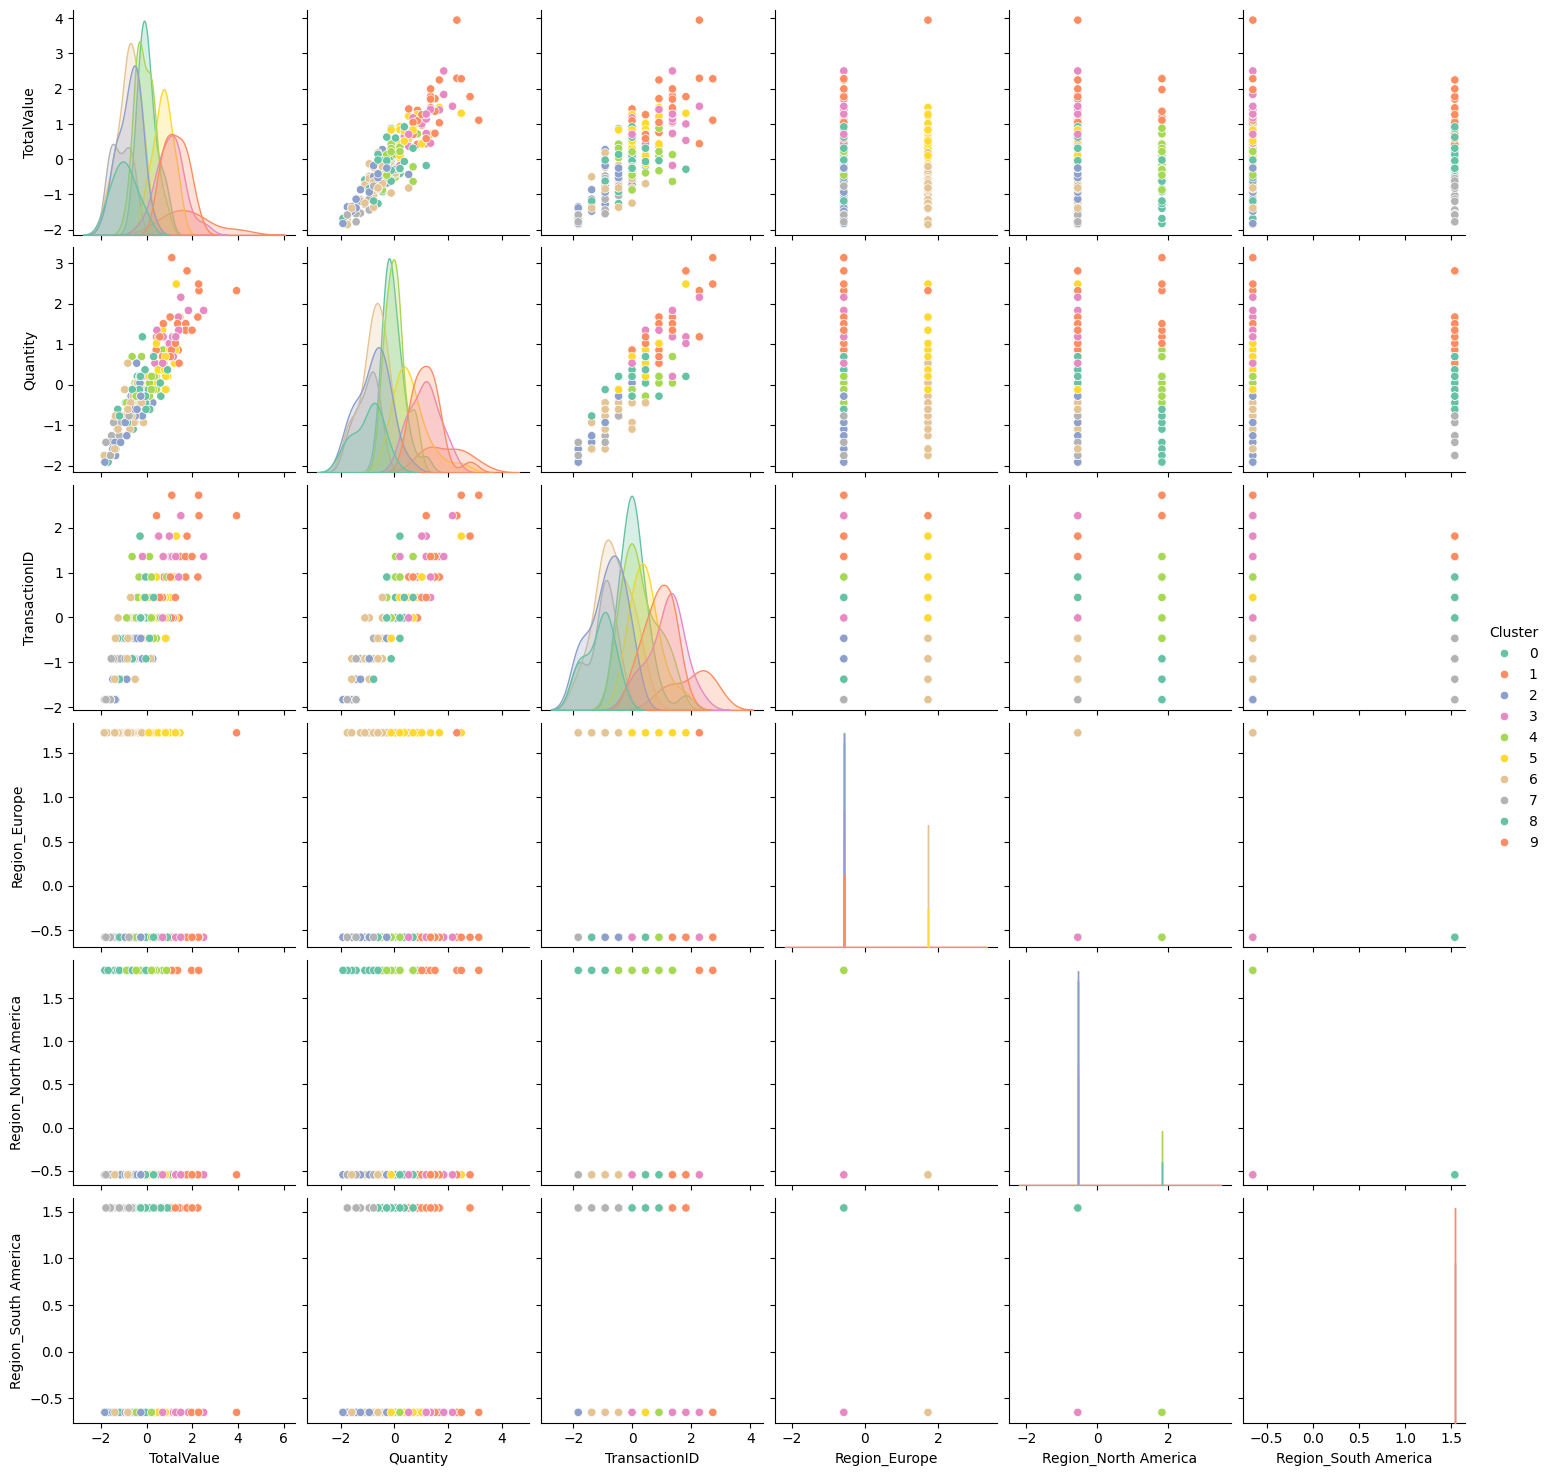

In [6]:
scaled_data = pd.DataFrame(X, columns=numerical_features)
scaled_data['Cluster'] = customer_summary['Cluster']

sns.pairplot(scaled_data, hue='Cluster', palette='Set2')
plt.show()

In [7]:
print("Clustering Results Summary:")
print(f"- Optimal Number of Clusters: {optimal_k}")
print(f"- Final Davies-Bouldin Index: {final_db_index}")
print(f"- Cluster Sizes:\n{cluster_sizes}")


Clustering Results Summary:
- Optimal Number of Clusters: 10
- Final Davies-Bouldin Index: 0.7848748526738405
- Cluster Sizes:
Cluster
6    29
2    26
4    26
8    25
5    20
1    19
3    18
7    15
0    13
9     8
Name: count, dtype: int64


### Trying with all other clustering algorithms like Aglomerative, DBSCAN, Spectral, GMM

Algorithm: KMeans
- Number of clusters: 10
- Davies-Bouldin Index: 0.785
- Silhouette Score: 0.442
--------------------
Algorithm: Agglomerative
- Number of clusters: 2
- Davies-Bouldin Index: 1.393
- Silhouette Score: 0.250
--------------------
Algorithm: DBSCAN
- Number of clusters: 8
- Davies-Bouldin Index: 1.395
- Silhouette Score: 0.016
--------------------
Algorithm: Spectral
- Number of clusters: 8
- Davies-Bouldin Index: 0.743
- Silhouette Score: 0.432
--------------------
Algorithm: GMM
- Number of clusters: 8
- Davies-Bouldin Index: 1.248
- Silhouette Score: 0.307
--------------------


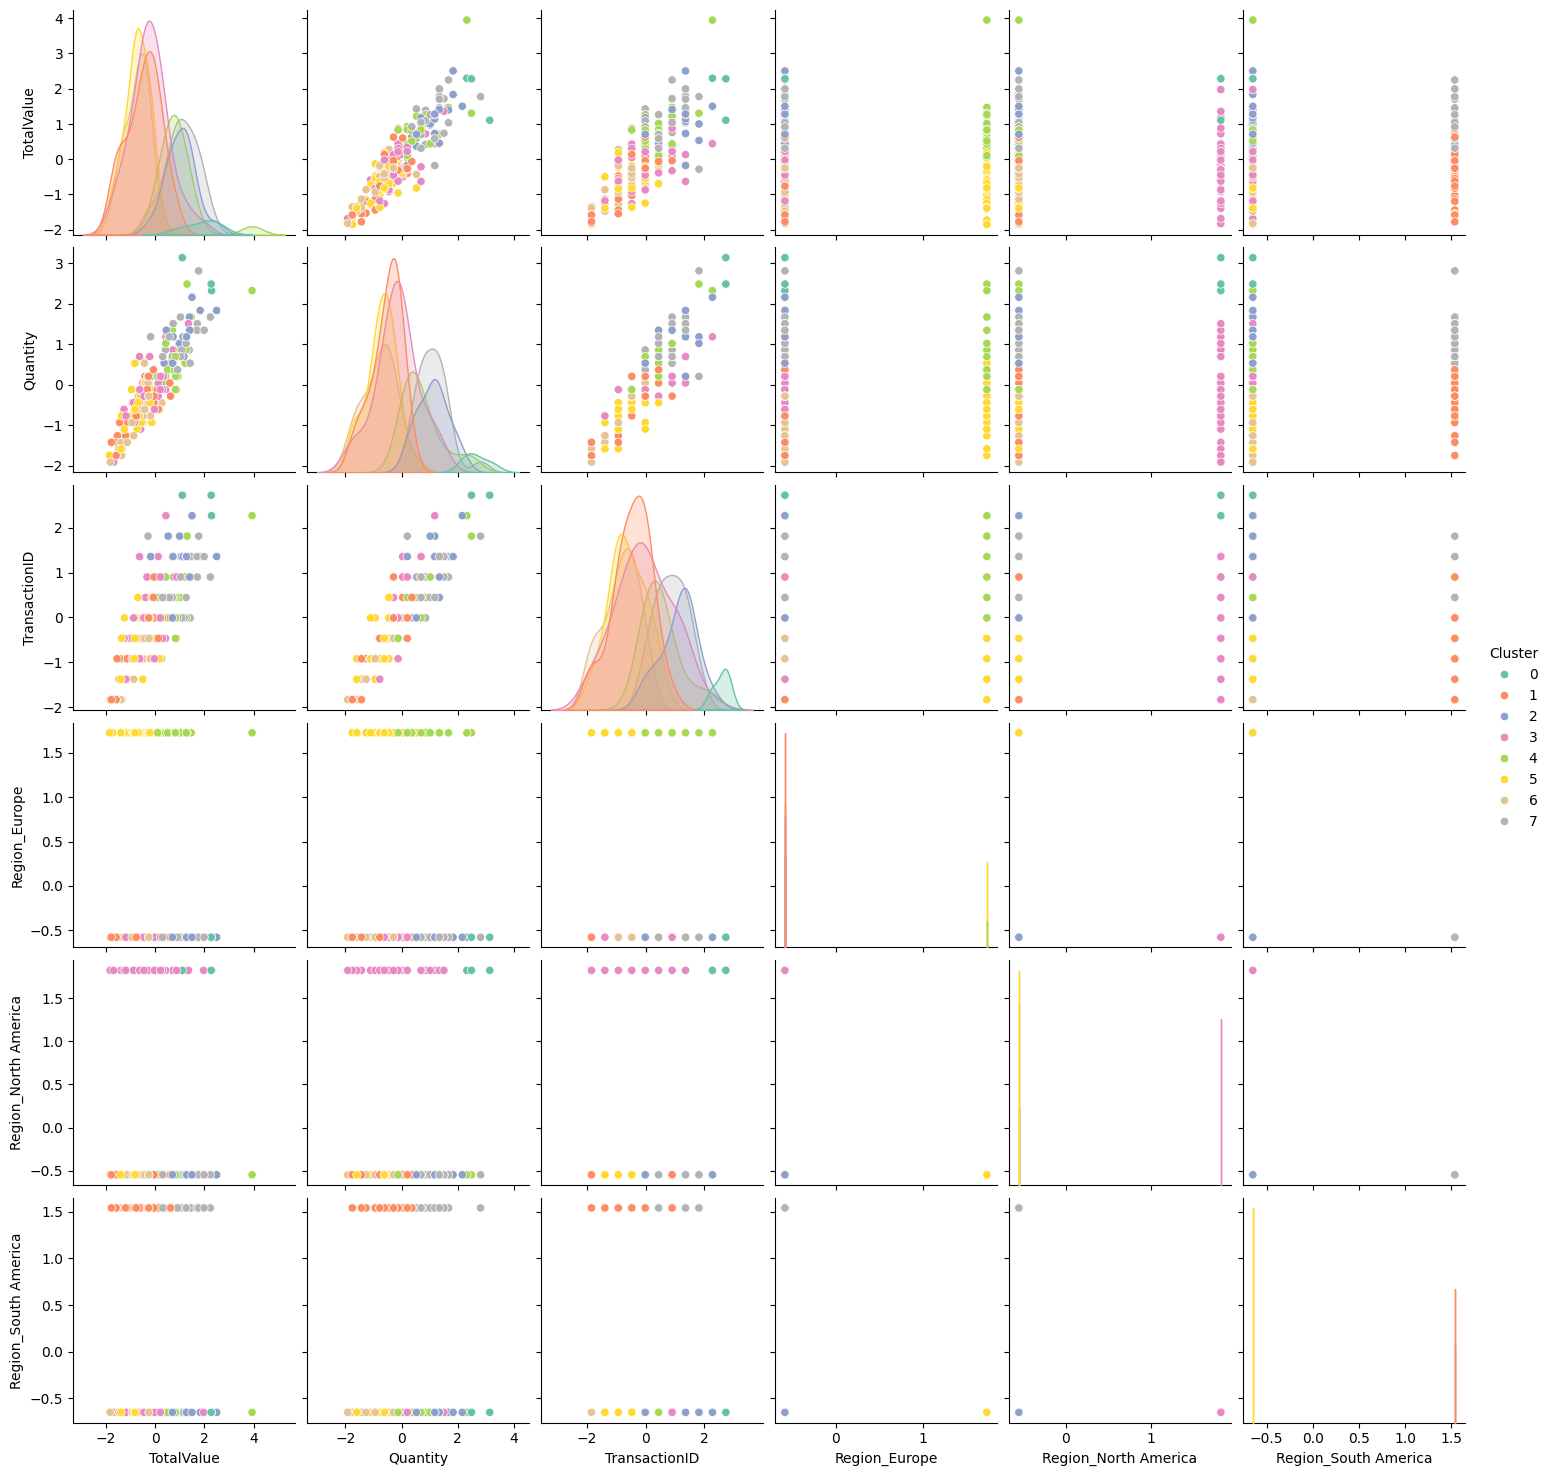

In [9]:

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')

customer_transactions = pd.merge(customers, transactions, on='CustomerID', how='inner')
customer_summary = customer_transactions.groupby('CustomerID').agg({
    'TotalValue': 'sum',
    'Quantity': 'sum',
    'TransactionID': 'count'
}).reset_index()
customer_summary = pd.merge(customer_summary, customers[['CustomerID', 'Region']], on='CustomerID', how='left')
customer_summary = pd.get_dummies(customer_summary, columns=['Region'], drop_first=True)

scaler = StandardScaler()
numerical_features = ['TotalValue', 'Quantity', 'TransactionID'] + [col for col in customer_summary.columns if 'Region_' in col]
X = scaler.fit_transform(customer_summary[numerical_features])


def evaluate_clustering(X, labels):
    db_index = davies_bouldin_score(X, labels)
    silhouette_avg = silhouette_score(X, labels)
    return db_index, silhouette_avg


# Clustering Algorithms
algorithms = {
    'KMeans': KMeans(random_state=42, n_init=10),
    'Agglomerative': AgglomerativeClustering(),
    'DBSCAN': DBSCAN(eps=0.5, min_samples=5),
    'Spectral': SpectralClustering(n_clusters=8,random_state=42,assign_labels='kmeans'), # You might need to tune n_clusters
    'GMM': GaussianMixture(n_components=8,random_state=42) # You might need to tune n_components
}

results = {}
for name, algo in algorithms.items():
    if name == 'KMeans':
        db_scores = []
        clusters_range = range(2, 11)
        for k in clusters_range:
            algo.set_params(n_clusters=k)
            labels = algo.fit_predict(X)
            db_index, silhouette = evaluate_clustering(X, labels)
            db_scores.append(db_index)
        optimal_k = clusters_range[np.argmin(db_scores)]
        algo.set_params(n_clusters=optimal_k)
        labels = algo.fit_predict(X)
        db_index, silhouette = evaluate_clustering(X, labels)
        results[name] = {'labels': labels, 'DB': db_index, 'Silhouette': silhouette, 'n_clusters': optimal_k}
    elif name == 'GMM':
        labels = algo.fit_predict(X)
        db_index, silhouette = evaluate_clustering(X, labels)
        results[name] = {'labels': labels, 'DB': db_index, 'Silhouette': silhouette, 'n_clusters': algo.n_components}
    else:
        labels = algo.fit_predict(X)
        db_index, silhouette = evaluate_clustering(X, labels)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        results[name] = {'labels': labels, 'DB': db_index, 'Silhouette': silhouette, 'n_clusters': n_clusters}

# Displaying results
for name, result in results.items():
    print(f"Algorithm: {name}")
    print(f"- Number of clusters: {result['n_clusters']}")
    print(f"- Davies-Bouldin Index: {result['DB']:.3f}")
    print(f"- Silhouette Score: {result['Silhouette']:.3f}")
    print("-" * 20)

# Further analysis/visualization (Example with the best algorithm)
best_algo = min(results, key=lambda k: results[k]['DB'])
best_labels = results[best_algo]['labels']

scaled_data = pd.DataFrame(X, columns=numerical_features)
scaled_data['Cluster'] = best_labels

sns.pairplot(scaled_data, hue='Cluster', palette='Set2')
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


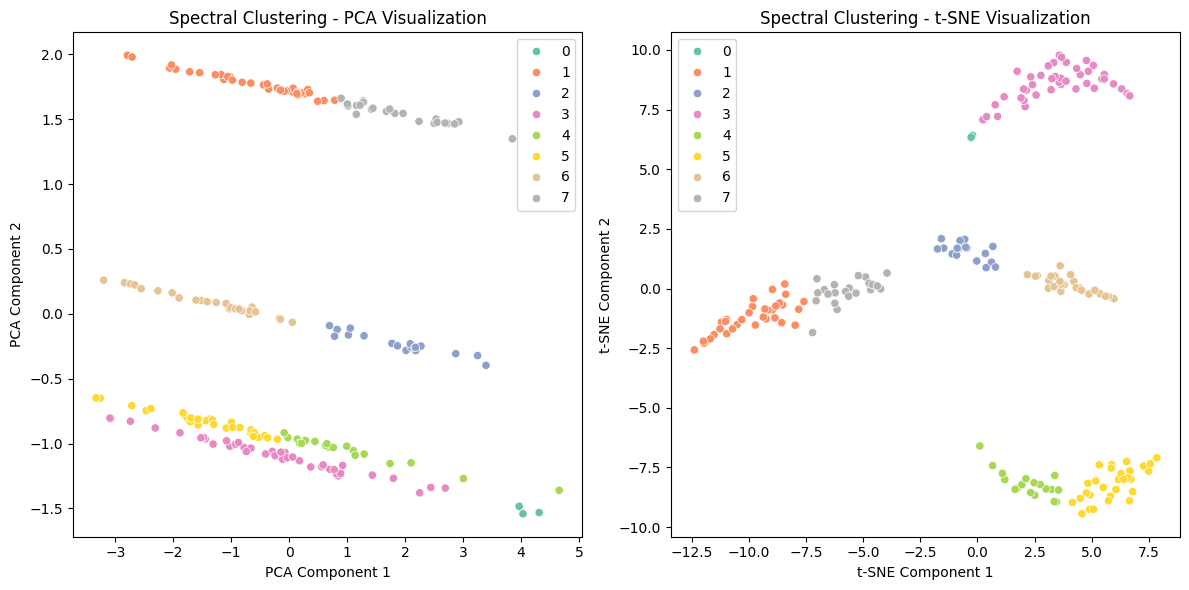

In [10]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

spectral_algo = SpectralClustering(n_clusters=8, random_state=42, assign_labels='kmeans')
spectral_labels = spectral_algo.fit_predict(X)

# PCA Visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=spectral_labels, palette='Set2', legend='full')
plt.title('Spectral Clustering - PCA Visualization')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

# t-SNE Visualization
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=300)
X_tsne = tsne.fit_transform(X)
plt.subplot(1, 2, 2)
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=spectral_labels, palette='Set2', legend='full')
plt.title('Spectral Clustering - t-SNE Visualization')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')

plt.tight_layout()
plt.show()
